In [20]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2
analysis.ipynb			 model.png
baseline			 multimodel_1
baseline_2			 multimodel_2
baseline_2_ckpt			 multi_model_2.ipynb
baseline_3			 multi_model.ipynb
baseline_3_ckpt			 multimodel_model.ipynb
baseline_3_forSub		 multimodel_with_baseline
baseline_3_training_smooth	 multimodel_with_baseline_2
baseline_3_training_smooth_ckpt  multimodel_with_baseline_3
baseline_4			 my_net
baseline_4_ckpt			 my_net_ckpt
baseline_5			 my_net.ipynb
baseline_5_ckpt			 simple
baseline_ckpt			 simple_ckpt
baseline.ipynb			 smooth_with_fft.ipynb
d2ee2_ERR_smooth_training.ipynb  smooth_with_lowpass.ipynb
d2ee2_smooth_training.ipynb	 smooth_with_regression7.ipynb
err_7.csv			 smooth_with_regression.ipynb
inno_training_fft_1		 Training.csv
inno_training_smooth		 Training_fft1.csv
inno_training_smooth_2		 Training_lowpass1.csv
inno_training_smooth_3		 Training

In [21]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq
import matplotlib.pyplot as plt

In [22]:
dataset = pd.read_csv('./Training.csv')
np.random.seed(1234)

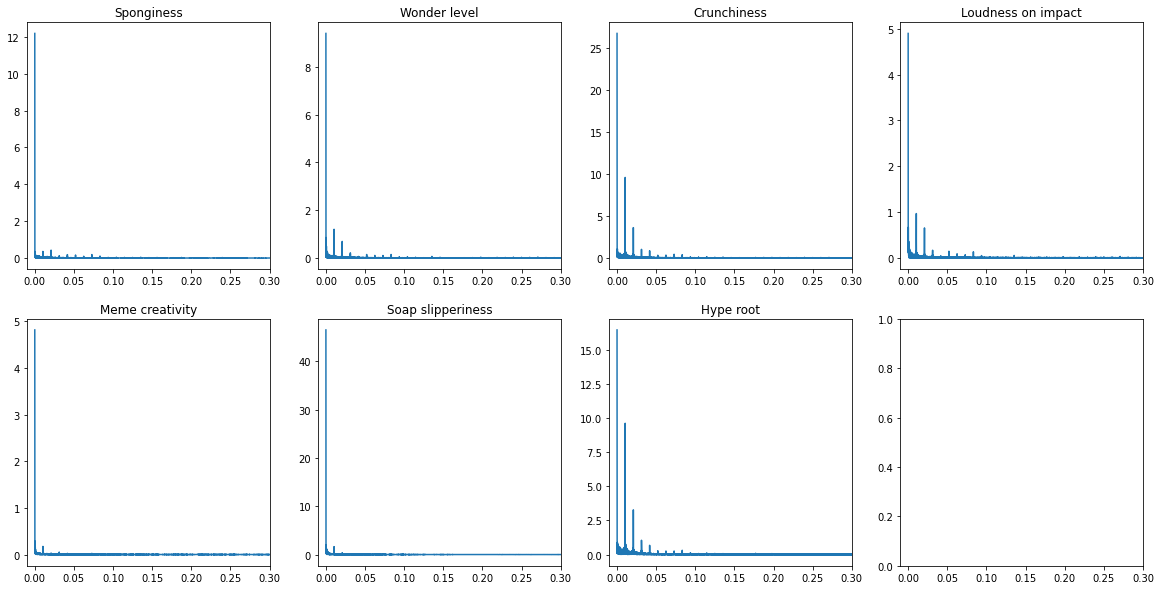

In [23]:
x = np.array(dataset['Crunchiness'])
N = len(x)
T = 1
time_step = 1

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20, 10)
plt.setp(axs, xlim=[-0.01,0.3])

i = 0
j = 0
for d in dataset:
  x = np.array(dataset[d])
  yf = fft(x)
  xf = fftfreq(N, T)[:N//2]
  axs[i, j].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
  axs[i, j].set_title(d)

  j = (j + 1)
  if j == 4:
    j = 0
    i += 1

In [24]:
# we hand pick the frequency on which to cut for each data
freq = {}
freq['Sponginess'] = 0.1
freq['Wonder level'] = 0.13
freq['Crunchiness'] = 0.13
freq['Loudness on impact'] = 0.1
# meme creativity is definitly too smooth to get anythnig useful: let's get just the mean
freq['Meme creativity'] = 0.005
freq['Soap slipperiness'] = 0.08
freq['Hype root'] = 0.1

In [25]:
from sklearn.metrics import mean_squared_error

def compute_rmse(x, y):
  rmse = mean_squared_error(x, y, squared=False)
  print("rmse:", rmse)
  return rmse

def visualize(x, r, inf=40, sup=400):
  discarded = len(x) - np.array(r).shape[0] 
  print("we discarded ", discarded, "initial points")
  compute_rmse(x[discarded:], r)

  x_ax = np.arange(sup - inf)
  plt.figure(figsize=(10, 6))
  plt.scatter(x_ax, x[inf + discarded:sup + discarded])
  plt.plot(x_ax, r[inf:sup], c='red')
  
  plt.show()

In [26]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def compute_filtered_sig(x, cutoff, fs, order=5, draw=False, title=''):
  b, a = butter_lowpass(cutoff, fs, order)
  w, h = freqz(b, a, worN=8000)
  if draw:
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title(title + " - Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

  data = x
  t = np.arange(len(data))
  y = butter_lowpass_filter(data, cutoff, fs, order)
  compute_rmse(x, y)
  if draw:
    plt.subplot(2, 1, 2)
    plt.plot(t, data, 'b-', label='data')
    plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()
    plt.subplots_adjust(hspace=0.35)
    plt.show()

  return y
# Filter requirements.

# order = 6
# fs = 1       # sample rate, Hz
# cutoff = 0.025 # desired cutoff frequency of the filter, Hz
# x = dataset['Crunchiness']
# y = compute_filtered_sig(x, cutoff, fs, order, True)

# visualize(x, y, 500, 700)

rmse: 1.1120618163427989


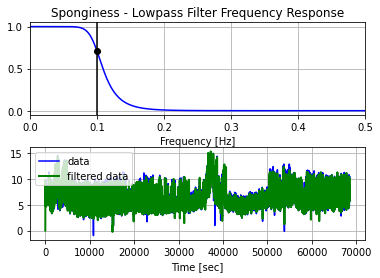

we discarded  0 initial points
rmse: 1.1120618163427989


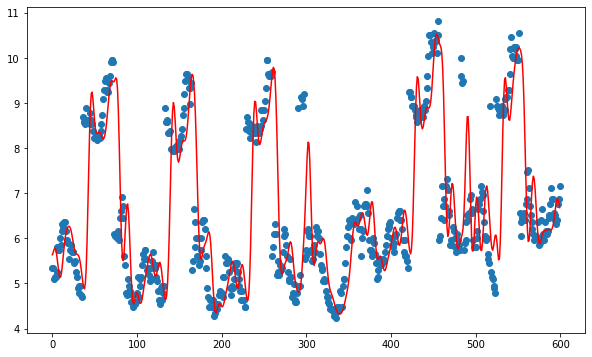

rmse: 1.2581493378793671


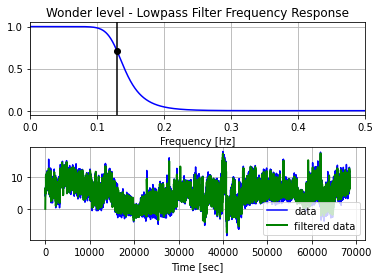

we discarded  0 initial points
rmse: 1.2581493378793671


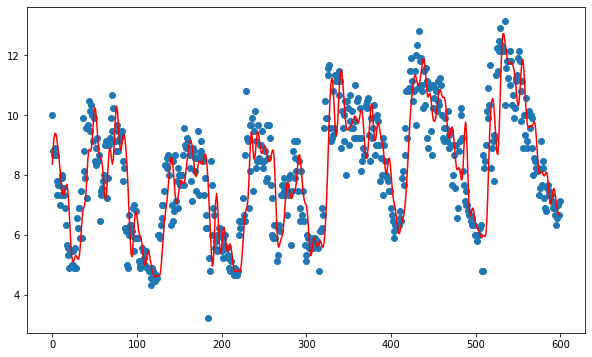

rmse: 4.996820467052663


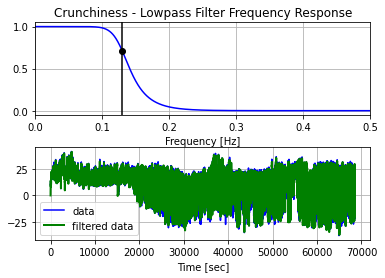

we discarded  0 initial points
rmse: 4.996820467052663


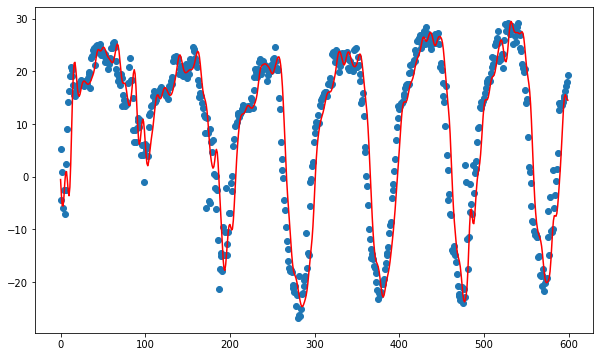

rmse: 1.2451007635046691


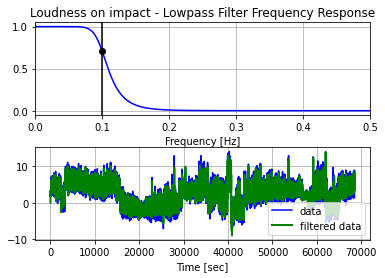

we discarded  0 initial points
rmse: 1.2451007635046691


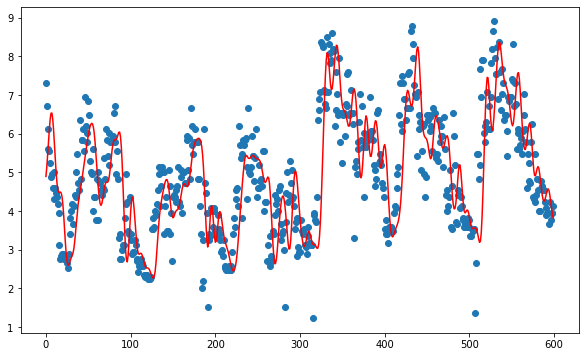

rmse: 0.5799106438882767


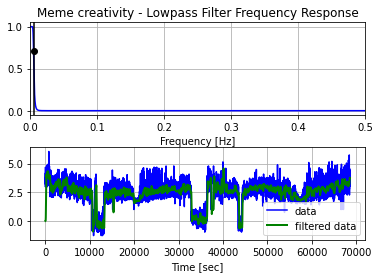

we discarded  0 initial points
rmse: 0.5799106438882767


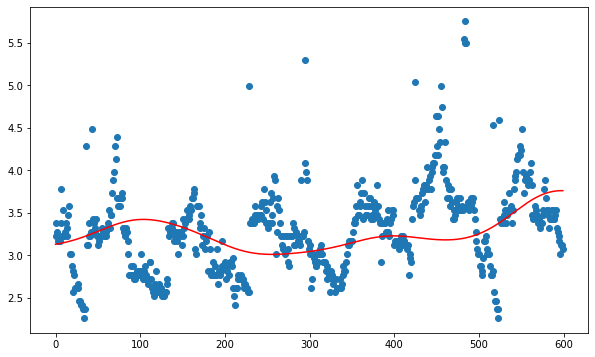

rmse: 2.063387826474846


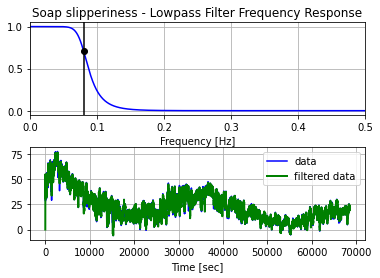

we discarded  0 initial points
rmse: 2.063387826474846


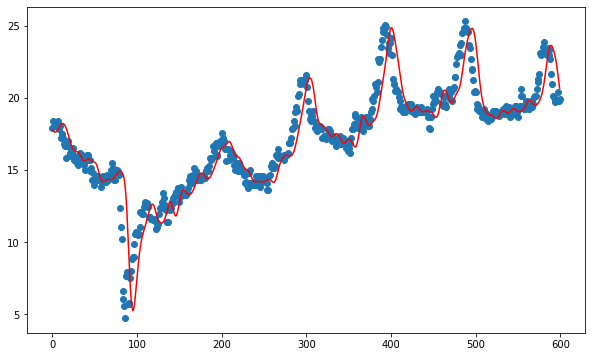

rmse: 5.75588330937937


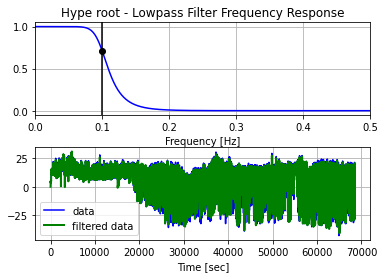

we discarded  0 initial points
rmse: 5.75588330937937


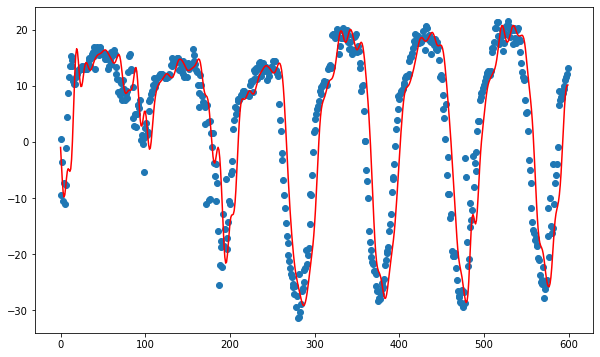

In [27]:
order = 6
fs = 1  
draw = True

new = {}
for i in dataset:
  x = dataset[i]
  new[i] = compute_filtered_sig(x, freq[i], fs, order, draw, i)
  if draw: visualize(x, new[i], len(new[i]) - 600, len(new[i]))
new = pd.DataFrame.from_dict(new, dtype=np.float64)

In [28]:
save = True
if save:
  new.to_csv('Training_lowpass1.csv', index=False)